In [1]:
# import packages
import os
from glob import glob
import geopandas as gpd
from pathlib import Path
from typing import List, Union
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
import rasterio as rio
import datetime
from datetime import datetime, timedelta
import sys
import pandas as pd
import seaborn as sns
from scipy.stats import linregress

In [2]:
# set up paths, directories, and variables for this specific dam
data_path = '/home/jovyan/repos/fufiters_imja_analysis/data'
asc_burst = '012_023790_IW1'
des_burst = '121_258661_IW2'
asc_burst_path = f'{data_path}/data_igrams/{asc_burst}'
des_burst_path = f'{data_path}/data_igrams/{des_burst}'

dam_name = 'imja'
proc_path = f'/home/jovyan/repos/fufiters_imja_analysis/analysis'

# define reference point, [y, x]
reference_point = [3086715.2, 491092.4]

# define crs 
crs = 32645

In [3]:
# functions to load interferogram tifs to xarray
def xr_read_geotif(geotif_file_path, masked=True):
    """
    Reads in single or multi-band GeoTIFF as dask array.
    Inputs
    ----------
    GeoTIFF_file_path : GeoTIFF file path
    Returns
    -------
    ds : xarray.Dataset
        Includes rioxarray extension to xarray.Dataset
    """

    da = rioxarray.open_rasterio(geotif_file_path, masked=True)

    # Extract bands and assign as variables in xr.Dataset()
    ds = xr.Dataset()
    for i, v in enumerate(da.band):
        da_tmp = da.sel(band=v)
        da_tmp.name = "band" + str(i + 1)

        ds[da_tmp.name] = da_tmp

    # Delete empty band coordinates.
    # Need to preserve spatial_ref coordinate, even though it appears empty.
    # See spatial_ref attributes under ds.coords.variables used by rioxarray extension.
    del ds.coords["band"]

    # Preserve top-level attributes and extract single value from value iterables e.g. (1,) --> 1
    ds.attrs = da.attrs
    for key, value in ds.attrs.items():
        try:
            if len(value) == 1:
                ds.attrs[key] = value[0]
        except TypeError:
            pass

    return ds

def hyp3_to_xarray(hyp3_dir, file_type='corr', epsg=32645, interpolate_na=False):
    
    dirs = os.listdir(hyp3_dir) #list generated interferograms
    datasets = []
    acquisition_list = []
    
    for idir in dirs:
        tif_path = glob(f'{hyp3_dir}/{idir}/*/*{file_type}.tif')[0]
        tif_fn = os.path.split(tif_path)[-1]
        dates = f'{tif_fn[14:22]}_{tif_fn[23:31]}' #parse filename for interferogram dates
        start_date = datetime.strptime(dates[:8], '%Y%m%d')
        end_date = datetime.strptime(dates[-8:], '%Y%m%d')
        t_baseline = end_date - start_date
        
        src = xr_read_geotif(tif_path, masked=False) #read product to xarray ds
        src = src.assign_coords({"dates": dates})
        src = src.expand_dims("dates")
        
        src = src.assign_coords(start_date = ('dates', [start_date]))
        src = src.assign_coords(end_date = ('dates', [end_date]))
        src = src.assign_coords(t_baseline = ('dates', [t_baseline]))
        
        src = src.rename({'band1':file_type})
        src = src.rio.write_crs(epsg)
        # in future, should get spatial baseline, flight dir, and orbit from metadata
        
        if interpolate_na == True:
            src = src.interpolate_na(dim='x', method='linear').fillna(value=0)
        
        datasets.append(src)
        #print(src[file_type].shape, src.dates.item())
       
    ds = xr.concat(datasets, dim="dates", combine_attrs="no_conflicts") #create dataset
    ds = ds.sortby('dates')

    return ds 

In [4]:
asc_corr_ds = hyp3_to_xarray(asc_burst_path, file_type=f'corr_{dam_name}')
des_corr_ds = hyp3_to_xarray(des_burst_path, file_type=f'corr_{dam_name}')

In [5]:
asc_burst_offsets_path = f'{data_path}/data_offsets/{asc_burst}'
des_burst_offsets_path = f'{data_path}/data_offsets/{des_burst}'

In [6]:
# open offsets
asc_offset_ds = hyp3_to_xarray(asc_burst_offsets_path, file_type=f'rng_off_{dam_name}')
des_offset_ds = hyp3_to_xarray(des_burst_offsets_path, file_type=f'rng_off_{dam_name}')

In [31]:
asc_corr_ds

<xarray.Dataset> Size: 767MB
Dimensions:      (x: 552, y: 546, dates: 636)
Coordinates:
  * x            (x) float64 4kB 4.857e+05 4.857e+05 ... 4.967e+05 4.967e+05
  * y            (y) float64 4kB 3.092e+06 3.092e+06 ... 3.081e+06 3.081e+06
  * dates        (dates) <U17 43kB '20170123_20170204' ... '20240216_20240228'
    start_date   (dates) datetime64[ns] 5kB 2017-01-23 2017-01-23 ... 2024-02-16
    end_date     (dates) datetime64[ns] 5kB 2017-02-04 2017-02-16 ... 2024-02-28
    t_baseline   (dates) timedelta64[ns] 5kB 12 days 24 days ... 24 days 12 days
    spatial_ref  int64 8B 0
Data variables:
    corr_imja    (dates, y, x) float32 767MB 0.9899 0.982 0.9694 ... nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [17]:
asc_corr_ds.dates

<xarray.DataArray 'dates' (dates: 636)> Size: 43kB
array(['20170123_20170204', '20170123_20170216', '20170123_20170228', ...,
       '20240204_20240216', '20240204_20240228', '20240216_20240228'],
      dtype='<U17')
Coordinates:
  * dates        (dates) <U17 43kB '20170123_20170204' ... '20240216_20240228'
    start_date   (dates) datetime64[ns] 5kB 2017-01-23 2017-01-23 ... 2024-02-16
    end_date     (dates) datetime64[ns] 5kB 2017-02-04 2017-02-16 ... 2024-02-28
    t_baseline   (dates) timedelta64[ns] 5kB 12 days 24 days ... 24 days 12 days
    spatial_ref  int64 8B 0

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

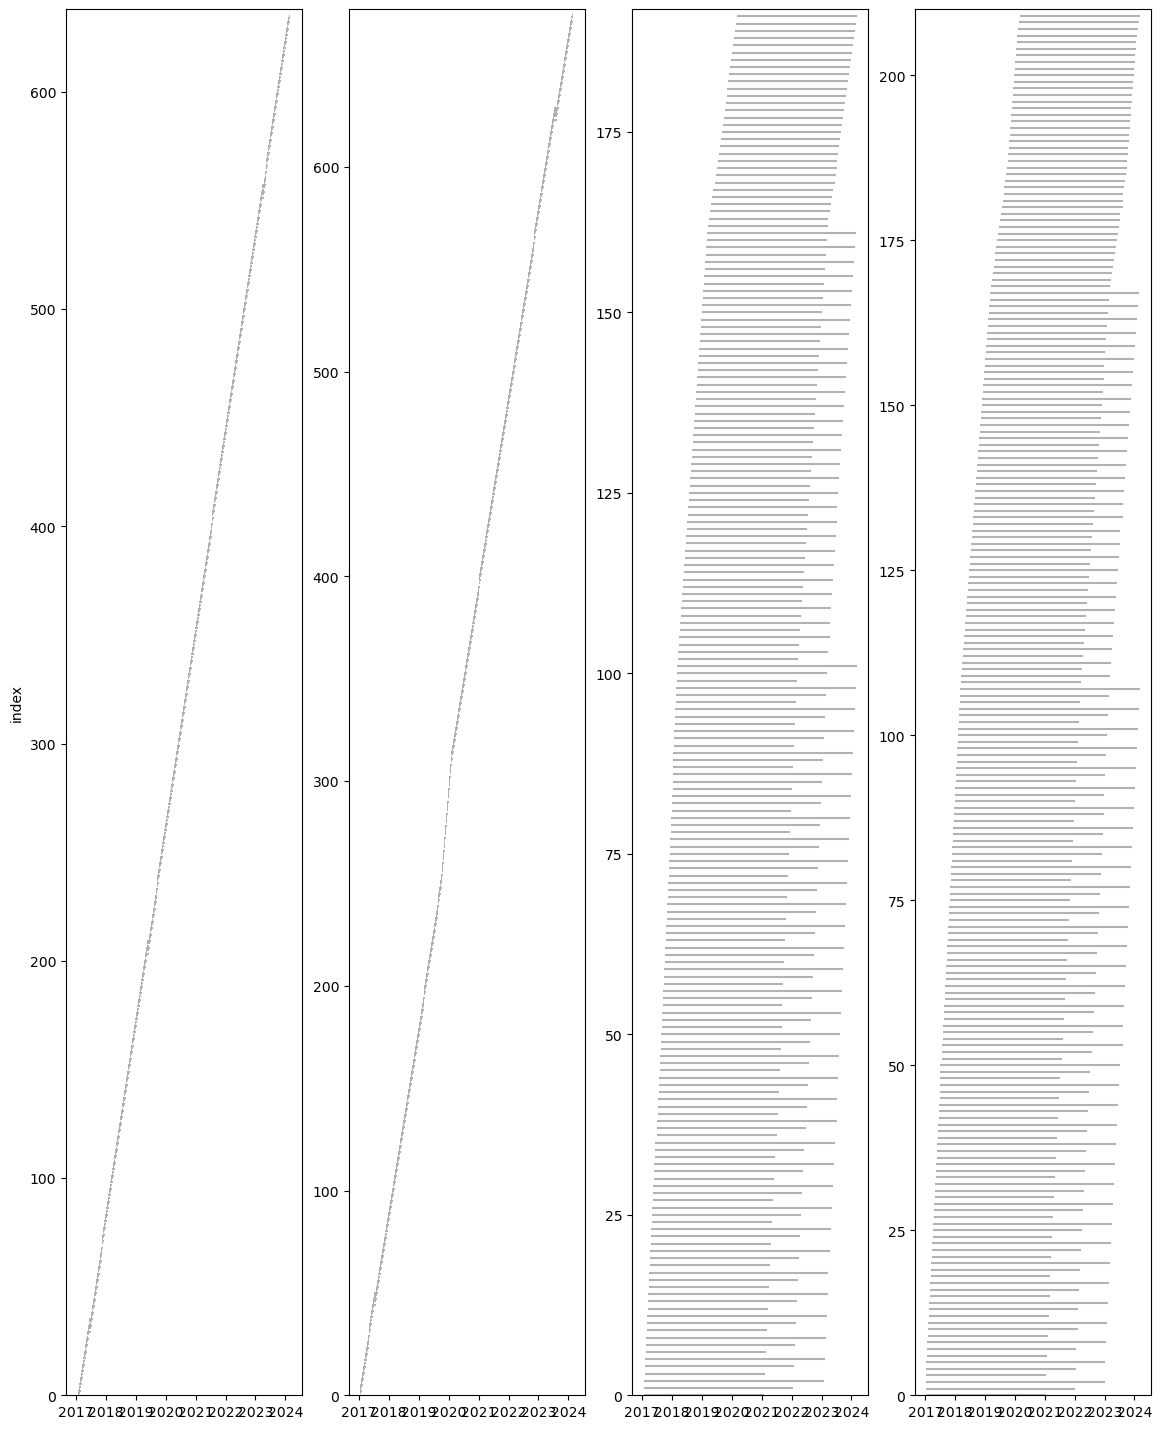

In [30]:
f, ax = plt.subplots(1, 4, figsize=(14, 18), sharex=True, sharey=False)
ax[0].hlines(y=range(len(asc_corr_ds.dates)),
     xmin=asc_corr_ds.start_date,
     xmax=asc_corr_ds.end_date,
     color='gray', alpha=0.6, zorder=1)
ax[1].hlines(y=range(len(des_corr_ds.dates)),
     xmin=des_corr_ds.start_date,
     xmax=des_corr_ds.end_date,
     color='gray', alpha=0.6, zorder=1)
ax[2].hlines(y=range(len(asc_offset_ds.dates)),
     xmin=asc_offset_ds.start_date,
     xmax=asc_offset_ds.end_date,
     color='gray', alpha=0.6, zorder=1)
ax[3].hlines(y=range(len(des_offset_ds.dates)),
     xmin=des_offset_ds.start_date,
     xmax=des_offset_ds.end_date,
     color='gray', alpha=0.6, zorder=1)

ax[0].set_ylim(0, len(asc_corr_ds.dates)+2)
ax[1].set_ylim(0, len(des_corr_ds.dates)+2)
ax[2].set_ylim(0, len(asc_offset_ds.dates))
ax[3].set_ylim(0, len(des_offset_ds.dates))

ax[0].set_ylabel('index')
ax[0].set_ylabel('index')
# ax[j].set_xlabel('date')
# ax[0].set_title(f'asc mean coherence')
# ax[1].set_title(f'des mean coherence')
# ax[2].set_title(f'des mean coherence')
# ax[0].legend(loc='upper left')
ax[1, 0].tick_params('x', labelrotation=45)
ax[1, 1].tick_params('x', labelrotation=45)
f.tight_layout()
# plt.savefig(f'../figs/{feature_name}_coherence_ts.png', dpi=300)